In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "17_12_2025",
                'genotype_dir': "R20A02_R56H10_split_CsChrimsontdT_synaptopHluorinVAMP2/pilots",
                'fly': 'fly1',
                'session': 'baseline_opto_response-001',
                'full_genotype': '',
                'ecl date': '',
                'notes': ''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                        )


In [3]:
pp.extract_metadata()
pp.bruker_to_h5(overwrite=True,first_chan=1)



num_cycles > 1, assuming z stacks
sample (308, 300)
(2, 1645, 5, 308, 300)
[########################################] | 100% Completed | 40.50 s


In [4]:
pp.metadata['layout']

{'sequences': 1645, 'frames_per_sequence': 5, 'samples_per_pixel': 5}

In [5]:
print(pp.data.shape)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)

(2, 1645, 5, 308, 300)


In [6]:
nap = pp.open_napari()

In [7]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [27]:
y_or = pp.calculate_zscored_F('outer_ring', exp_detrend=False,zscore=False)

In [28]:
pp.save()

(2, 1, 1645)


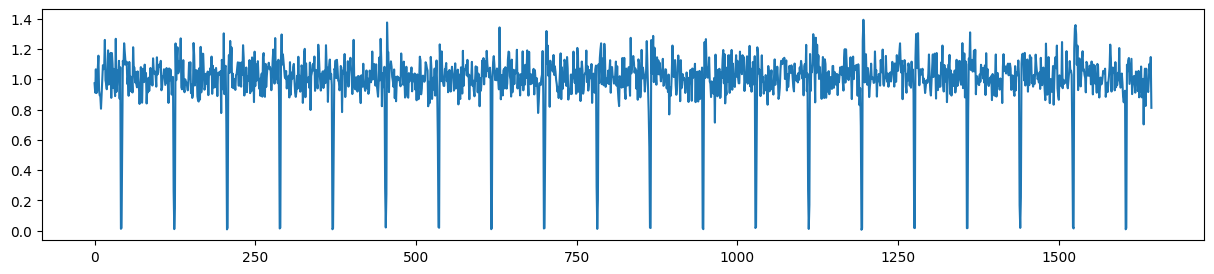

In [30]:
fig, ax = plt.subplots(figsize = [ 15,3])
ax.plot(y_or[1,0,:])
print(y_or.shape)

In [11]:
np.array(pp.metadata['frame_times']).shape

(1645, 5)

In [31]:
def get_stims(pp):

    frame_times = np.array(pp.metadata['frame_times']).mean(axis=1)
    dt = (frame_times[1:]-frame_times[:-1]).mean()

    stim_times = [pp.metadata['mark_points']['initial_delay']]
    for i in range(pp.metadata['mark_points']['repetitions']-1):
        stim_times.append(pp.metadata['mark_points']['inter_point_delay']+pp.metadata['mark_points']['duration'])
    stim_times = np.array(stim_times)/1000
    stim_times = np.cumsum(stim_times)
    
    
    stim_inds = []
    for time in stim_times:
        stim_inds.append( np.argwhere((frame_times-time)>0)[0][0])
    stim_inds = np.array(stim_inds)
    print(stim_inds)
    
    stim_resp = np.zeros((len(stim_inds), 80))
    print(stim_resp.shape)
    for i, ind in enumerate(stim_inds[:-1]):
        print(i)
        stim_resp[i,:] = y_or[-1,0,ind-10:ind+70]
    stim_resp -= np.nanmean(stim_resp[:,:10], axis=-1, keepdims=True)
    return frame_times, dt, stim_inds, stim_resp

In [32]:
frame_times, dt, stim_inds, stim_resp = get_stims(pp)

[  41  123  206  288  370  452  535  617  699  781  864  946 1028 1110
 1193 1275 1357 1439 1522 1604]
(20, 80)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


Text(0.5, 1.0, 'Synapto-pHluorin-Vamp2 (50 microM Picrotoxin, 25 microM curare)')

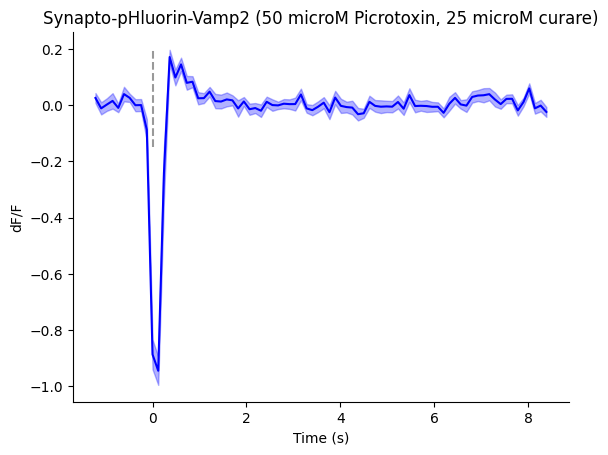

In [33]:
fig, ax= plt.subplots()
mu = np.mean(stim_resp[:,:],axis=0)
sem = sp.stats.sem(stim_resp,axis=0, nan_policy='omit')

x = np.arange(-10*dt, 69*dt+1E-3, dt) 
ax.plot(x, mu, color='blue')
ax.fill_between(x, mu-sem, mu+sem, color='blue', alpha=.3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('dF/F')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot([0,0],[-.15,.2], 'k--',alpha=.4)
ax.set_title('Synapto-pHluorin-Vamp2 (50 microM Picrotoxin, 25 microM curare)')
